# Conformal Prediction Minimal Implementation

As a basic introduction to conformal prediction, this notebook trains a simple classifier for CIFAR10 prediction, and then adds conformal prediction on top to give prediction sets.

In [20]:
import jax
import torch
import numpy as np
import jax.numpy as jnp
import flax.linen as nn

from einops import rearrange
from pprint import pprint
from torch.utils.data import default_collate, DataLoader
from torchvision.datasets import CIFAR10

## Pull in the data and transform it

In [21]:
def pil_to_tensor(img):
    """Convert a PIL Image to a JAX array scaled to [0,1] or rearranged for non-MNIST images."""
    return torch.tensor(np.array(img), dtype=torch.float32) / 255.0

def numpy_collate(batch):
  return jax.tree.map(jnp.asarray, default_collate(batch))

def one_hot(batch):
   batch = torch.tensor(batch)
   return torch.nn.functional.one_hot(batch, num_classes=10)

dataset_gen = torch.Generator().manual_seed(42)

trainvalset = CIFAR10(download=True, root='../data/', train=True, transform=pil_to_tensor, target_transform=one_hot)
testset = CIFAR10(download=True, root='../data/', train=False, transform=pil_to_tensor, target_transform=one_hot)
# split out a validation set
trainset = torch.utils.data.Subset(trainvalset, indices=range(40_000))
valset = torch.utils.data.Subset(trainvalset, indices=range(40_000, 50_000))
# conver to dataloaders
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, generator=dataset_gen, collate_fn=numpy_collate)
valloader = DataLoader(valset, batch_size=64, shuffle=True, generator=dataset_gen, collate_fn=numpy_collate)
testloader = DataLoader(testset, batch_size=64, shuffle=True, generator=dataset_gen, collate_fn=numpy_collate)

## Define and instantiate the model

In [22]:
class CIFARClassifier(nn.Module):
    """Minimal CNN for CIFAR-10."""
    num_classes: int = 10

    @nn.compact
    def __call__(self, x: jnp.ndarray, *, train: bool = True) -> jnp.ndarray:
        # Block 1
        x = nn.Conv(32, (3, 3))(x)      # 32×32 → 30×30, 32 ch
        x = nn.relu(x)
        x = nn.Conv(64, (3, 3))(x)      # 30×30 → 28×28, 64 ch
        x = nn.relu(x)
        x = nn.avg_pool(x, (2, 2), (2, 2))  # 28×28 → 14×14

        # Block 2
        x = nn.Conv(128, (3, 3))(x)     # 14×14 → 12×12, 128 ch
        x = nn.relu(x)
        x = nn.avg_pool(x, (2, 2), (2, 2))  # 12×12 → 6×6

        # Head
        x = rearrange(x, 'b h w d -> b (h w d)')     # flatten: 6×6×128 = 4608
        x = nn.Dense(256)(x)
        x = nn.relu(x)
        x = nn.Dropout(0.5, deterministic=not train)(x)
        x = nn.Dense(self.num_classes)(x)   # logits shape: (batch, 10)
        return x

In [23]:
for x, y in trainloader:
    break

assert type(x) is type(y) is type(jnp.ones(5))
print(f'x:{x.shape}, y:{y.shape}')

x:(64, 32, 32, 3), y:(64, 10)


In [24]:
key = jax.random.key(42)
key, subkey = jax.random.split(key)

model = CIFARClassifier()

params = model.init(subkey, x)
pprint(jax.tree.map(jnp.size, params), underscore_numbers=True)

{'params': {'Conv_0': {'bias': 32, 'kernel': 864},
            'Conv_1': {'bias': 64, 'kernel': 18_432},
            'Conv_2': {'bias': 128, 'kernel': 73_728},
            'Dense_0': {'bias': 256, 'kernel': 2_097_152},
            'Dense_1': {'bias': 10, 'kernel': 2_560}}}


## Train the image classifier

In [35]:
import optax
from flax.training.train_state import TrainState

n_epochs = 10
lr = 1e-3
dropout_key = jax.random.key(42)

tx = optax.adamw(lr)
state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)

@jax.jit
def train_step(state: TrainState, x, y, dropout_rng):
    def loss_fn(params: jnp.ndarray):
        logits = state.apply_fn(params, x, rngs={'dropout': dropout_rng})
        return optax.softmax_cross_entropy(logits, y).mean()
    
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return loss, state

@jax.jit
def eval_step(state: TrainState, x: jnp.ndarray, y: jnp.ndarray) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Performs a single evaluation step."""
    # Pass `train=False` to disable dropout
    logits = state.apply_fn(state.params, x, train=False)
    loss = optax.softmax_cross_entropy(logits, y).mean()
    accuracy = jnp.mean(jnp.argmax(logits, -1) == y.argmax(-1))
    return loss, accuracy

epoch_stats = []
for epoch in range(n_epochs):
    print(f'--- Epoch {epoch+1}')
    batch_losses = []
    for x, y in trainloader:
        dropout_key, subkey = jax.random.split(dropout_key)
        batch_loss, state = train_step(state, x, y, subkey)
        batch_losses.append(batch_loss)

    # calculate the validation loss
    # --- Evaluate on validation set ---
    val_losses = []
    val_accuracies = []
    for x, y in valloader:
        val_loss_batch, val_acc_batch = eval_step(state, x, y)
        val_losses.append(val_loss_batch)
        val_accuracies.append(val_acc_batch)
    # --- Compute average metrics for the epoch ---

    print(f'  Train loss:              {np.mean(batch_losses):.4f}')
    print(f'  Validation loss:         {np.mean(val_losses):.4f}')
    print(f'  Validation accuracy:     {np.mean(val_accuracies):.4f}\n')

--- Epoch 1
  Train loss:              1.5473
  Validation loss:         1.1882
  Validation accuracy:     0.5709

--- Epoch 2
  Train loss:              1.1285
  Validation loss:         0.9822
  Validation accuracy:     0.6633

--- Epoch 3
  Train loss:              0.9471
  Validation loss:         0.8587
  Validation accuracy:     0.7072

--- Epoch 4
  Train loss:              0.8222
  Validation loss:         0.8020
  Validation accuracy:     0.7179

--- Epoch 5
  Train loss:              0.7303
  Validation loss:         0.7695
  Validation accuracy:     0.7341

--- Epoch 6
  Train loss:              0.6403
  Validation loss:         0.7375
  Validation accuracy:     0.7468

--- Epoch 7
  Train loss:              0.5765
  Validation loss:         0.7252
  Validation accuracy:     0.7509

--- Epoch 8
  Train loss:              0.5076
  Validation loss:         0.7639
  Validation accuracy:     0.7474

--- Epoch 9
  Train loss:              0.4472
  Validation loss:         0.7803


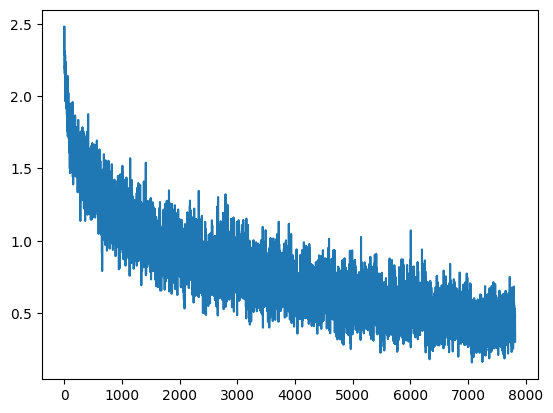

In [ ]:
# import matplotlib.pyplot as plt
# plt.plot(batch_losses)